In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.special import lambertw

import os

from matplotlib import pyplot as plt

from matplotlib_venn import venn2, venn3, venn3_circles, venn2_circles

import matplotlib.patches as patches

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.figsize': (8, 6)})

# SIR model

## Analytical & numerical results

/home/alex/miniconda3/envs/GEO/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


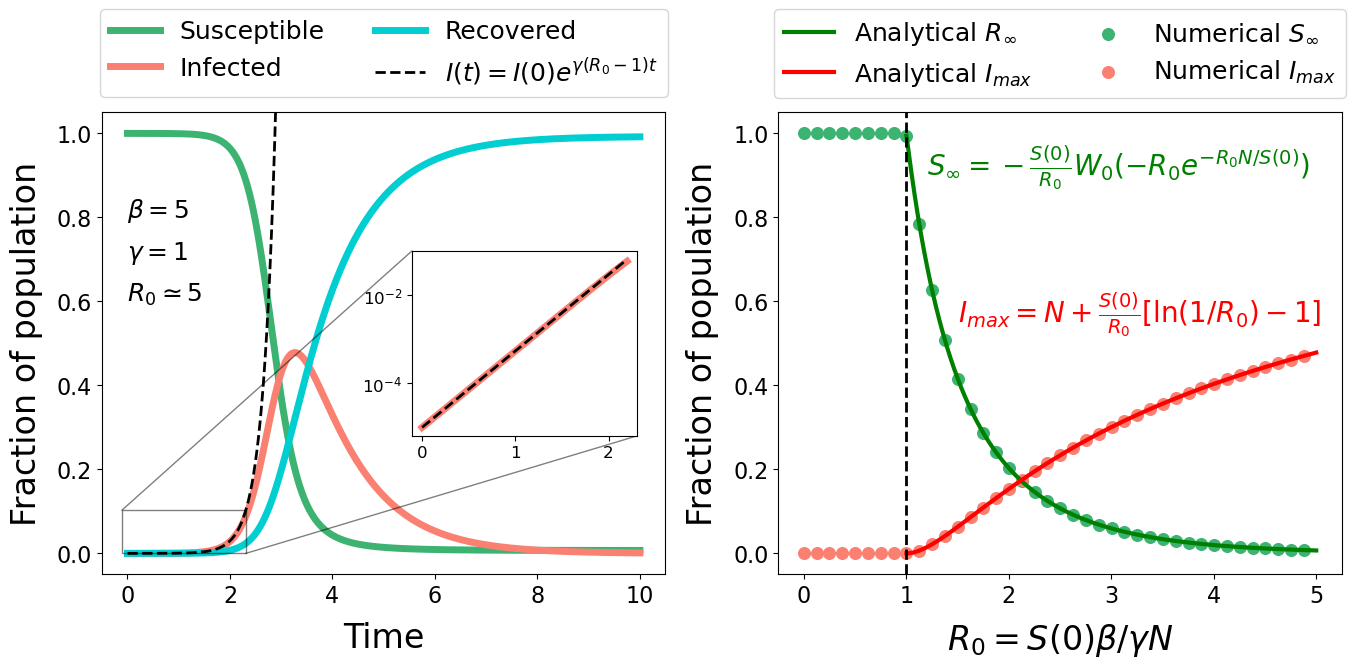

In [15]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def simulate_sir(S0, I0, R0, beta, gamma, N, t):
    y0 = S0, I0, R0
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    return S, I, R

def R0_sweep(S0, I0, beta, gamma, N, t, R0s):
    
    S_infs = []
    I_maxs = []
    
    for R0 in R0s:
        beta = R0 * gamma * N / S0
        S, I, R = simulate_sir(S0, I0, R0, beta, gamma, N, t)
        
        S_inf = S[-1]
        I_max = np.max(I)
        
        S_infs.append(S_inf)
        I_maxs.append(I_max)
        
    return np.array(S_infs), np.array(I_maxs)

def analytical_I_max(S0, R0, N):
    
    I_max = N + (S0/R0) * (np.log(1/R0) - 1)
    
    return I_max

def analytical_S_inf(S0, R0, N):
    
    S_inf = -(S0/R0) * lambertw(-R0 * np.exp(-R0 * N/S0))
    
    return S_inf
    
def exponential_approximation(t, I0, gamma, R_0):
    
    I = I0 * np.exp((gamma)*(R_0-1) * t)
    
    return I
    
# Simulation example

N = 100000
I0, R0 = 1, 0
S0 = N - I0 - R0

beta, gamma = 5, 1

tsim = np.linspace(0, 10, 10**4)

S, I, R = simulate_sir(S0, I0, R0, beta, gamma, N, tsim)
    
# Analytical results
t = np.linspace(0, 1000, 10**4)

R0s = np.linspace(0, 5, 1000)

R0s_pos = R0s[R0s > 1]
R0s_neg = R0s[R0s < 1]

S_infs, I_maxs = R0_sweep(S0, I0, beta, gamma, N, t, R0s)

S_infs_analytical = [analytical_S_inf(S0, R0, N)/N for R0 in R0s_pos]
I_maxs_analytical = [analytical_I_max(S0, R0, N)/N for R0 in R0s_pos]

# Figure
fig, ax = plt.subplot_mosaic("""AB""", figsize=(8*2,6))

ns_tsim = 35*100

ax["A"].plot(tsim, S/N, 'mediumseagreen', linewidth=5, label='Susceptible')
ax["A"].plot(tsim, I/N, 'salmon', linewidth=5, label='Infected')
ax["A"].plot(tsim, R/N, 'darkturquoise', linewidth=5, label='Recovered')
ax["A"].plot(tsim[0:ns_tsim], exponential_approximation(tsim[0:ns_tsim], I0, gamma, 5)/N, color='k', linestyle='--', lw=2, label=r'$I(t) = I(0) e^{\gamma(R_0-1) t}$')

ax["A"].set_xlabel('Time', fontsize=24, labelpad=10)
ax["A"].set_ylabel('Fraction of population', fontsize=24, labelpad=10)

ax["A"].set_ylim(-0.05, 1.05)

# Plot the parameters used and the R0
ax["A"].text(0, 0.8, r'$\beta=5$', fontsize=18, color='k')
ax["A"].text(0, 0.7, r'$\gamma=1$', fontsize=18, color='k')
ax["A"].text(0, 0.6, r'$R_0\simeq5$', fontsize=18, color='k')

ax["A"].legend(ncol=2, fontsize=18, loc='upper center', bbox_to_anchor=(0.5, 1.25))

## inset
axins = ax["A"].inset_axes([0.55, 0.3, 0.4, 0.4])

ns_tsim = 22*100

axins.plot(tsim[0:ns_tsim], I[0:ns_tsim]/N, 'salmon', linewidth=5, label='Infected')
axins.plot(tsim[0:ns_tsim], exponential_approximation(tsim[0:ns_tsim], I0, gamma, 5)/N, color='k', linestyle='--', lw=2)

axins.set_yscale("log")

# change tick size
axins.tick_params(axis='both', which='major', labelsize=12)

ax["A"].indicate_inset_zoom(axins, edgecolor="black")

sample = 25

ax["B"].plot(R0s_pos, S_infs_analytical, color="green", lw=3, label=r'Analytical $R_\infty$')
ax["B"].plot(R0s_pos, I_maxs_analytical, color="r", lw=3, label=r'Analytical $I_{max}$')

ax["B"].axvline(1, color='k', linestyle='--', lw=2)

ax["B"].scatter(R0s[0:-1:sample], S_infs[0:-1:sample]/N, color="mediumseagreen", marker="o", s=70, label=r'Numerical $S_\infty$')
ax["B"].scatter(R0s[0:-1:sample], I_maxs[0:-1:sample]/N, color="salmon", marker="o", s=70, label=r'Numerical $I_{max}$')

ax["B"].set_xlabel(r'$R_0=S(0)\beta/\gamma N$', fontsize=24, labelpad=10)
ax["B"].set_ylabel('Fraction of population', fontsize=24, labelpad=10)

# plot the analytical formulas
ax["B"].text(1.2, 0.9, r'$S_\infty = -\frac{S(0)}{R_0} W_0(-R_0 e^{-R_0 N/S(0)})$', fontsize=20, color='green')
ax["B"].text(1.5, 0.55, r'$I_{max} = N + \frac{S(0)}{R_0} \left[\ln(1/R_0) - 1\right]$', fontsize=20, color='red')

ax["B"].legend(ncol=2, fontsize=18, loc='upper center', bbox_to_anchor=(0.5, 1.25))

plt.savefig("SIR_model_analysis.pdf", dpi=600, bbox_inches='tight')

# Ecological niche theory

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

# Make a Basic Venn
v = venn3(subsets=(1, 1, 1, 1, 1, 1, 1), set_labels = ('A', 'B', 'C'))

# Custom it
v.get_patch_by_id('100').set_color('paleturquoise')
v.get_patch_by_id('010').set_color('palegreen')
v.get_patch_by_id('001').set_color('salmon')

# v.get_label_by_id('100').set_text('Grinnellian \n niche')
# v.get_label_by_id('110').set_text('Hutchinsonian \n niche')
# v.get_label_by_id('010').set_text('Eltonian \n niche')
v.get_label_by_id('100').set_text('')
v.get_label_by_id('110').set_text('')
v.get_label_by_id('010').set_text('')
v.get_label_by_id('101').set_text('')
v.get_label_by_id('011').set_text('')
v.get_label_by_id('001').set_text('')

v.get_patch_by_id('101').set_color('yellow')
v.get_patch_by_id('011').set_color('yellow')
v.get_patch_by_id('110').set_color('yellow')

v.get_patch_by_id('111').set_color('plum')

v.get_label_by_id('111').set_text('Realized \n niche')

v.get_label_by_id('A').set_text('Abiotic niche')
v.get_label_by_id('B').set_text('Biotic niche')
v.get_label_by_id('C').set_text('Movement niche')

c = venn3_circles(subsets=(1, 1, 1, 1, 1, 1, 1), linestyle='-', linewidth=1.25, color='black')
 
# Add title and annotation
plt.title("BAM framework", fontsize=20, fontweight='bold', color='black', pad=10)

#plt.savefig('BAM_framework.pdf', dpi=300, bbox_inches='tight')

In [ ]:
plt.figure(figsize=(8, 6))

# Make a Basic Venn
v = venn2(subsets=(1, 1, 1), set_labels = ('A', 'B'))

v.get_patch_by_id('10').set_color('paleturquoise')
v.get_patch_by_id('01').set_color('palegreen')

v.get_label_by_id('10').set_text('Grinnellian \n niche')
v.get_label_by_id('11').set_text('Hutchinsonian \n niche')
v.get_label_by_id('01').set_text('Eltonian \n niche')

v.get_patch_by_id('11').set_color('plum')

v.get_label_by_id('A').set_text('Abiotic niche')
v.get_label_by_id('B').set_text('Biotic niche')

c = venn2_circles(subsets=(1, 1, 1), linestyle='-', linewidth=1.25, color='black')
 
# Add title and annotation
plt.title("Historical perspective", fontsize=20, fontweight='bold', color='black', pad=10)

#plt.savefig('Historical_niches.pdf', dpi=300, bbox_inches='tight')

# SDMs

In [ ]:
# packages
import elapid as ela

import rasterio as rio
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import metrics
import warnings

import contextily as ctx

# paths
https = "https://earth-chris.github.io/images/research"
vector = f"{https}/ariolimax-buttoni.gpkg"
raster_names = [
    "ca-cloudcover-mean.tif",
    "ca-cloudcover-stdv.tif",
    "ca-leafareaindex-mean.tif",
    "ca-leafareaindex-stdv.tif",
    "ca-surfacetemp-mean.tif",
    "ca-surfacetemp-stdv.tif",
]
rasters = [f"{https}/{raster}" for raster in raster_names]
labels = [raster[3:-4] for raster in raster_names]

# read the presence data, draw background point samples
presence = gpd.read_file(vector)
background = ela.sample_raster(rasters[0], count=10_000)

# merge datasets and read the covariates at each point location
merged = ela.stack_geodataframes(presence, background, add_class_label=True)
annotated = ela.annotate(merged, rasters, drop_na=True, quiet=True)

# split the x/y data
x = annotated.drop(columns=['class', 'geometry'])
y = annotated['class']

# train the model
model = ela.MaxentModel(transform='cloglog', beta_multiplier=2.0)
model.fit(x, y)

# evaluate training performance
ypred = model.predict(x)
auc = metrics.roc_auc_score(y, ypred)
print(f"Training AUC score: {auc:0.3f}")

# write the model predictions to disk
output_raster = 'demo-maxent-predictions.tif'
ela.apply_model_to_rasters(model, rasters, output_raster, quiet=True)

# and read into memory
with rio.open(output_raster, 'r') as src:
    pred = src.read(1, masked=True)

fig, ax = plt.subplot_mosaic("""
                             AAAAAA
                             BBCCDD
                             EEEFFF
                             """, figsize=(6*2, 6*3))

background_f = background.to_crs(epsg=4326)
presence_f = presence.to_crs(epsg=4326)

presence_f.plot(ax=ax["A"], color='red', markersize=4, zorder=3)

ax['A'].set_ylim(20.0, 50)
ax['A'].set_xlim(-126, -65)

ax['A'].set_axis_off()

ctx.add_basemap(ax["A"], crs=presence_f.crs, source=ctx.providers.OpenTopoMap, zoom=4, alpha=0.7) #ctx.providers.OpenStreetMap.Mapnik, ctx.providers.Esri.WorldStreetMap

handles = [mpl.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label=r'$\it{Ariolimax} \ \it{buttoni}$')]

ax['A'].legend(handles=handles, loc='upper right', fontsize=14)

# Plot the environmental data
newlabels = [
    "Cloud Cover Mean",
    "Cloud Cover Std. Dev.",
    "Leaf Area Index Mean",
    "Leaf Area Index Std. Dev.",
    "Surface Temp. Mean",
    "Surface Temp. Std. Dev.",
]

letters_k = ['B', 'C', 'D']

k = -1
for i, (raster, newlabel) in enumerate(zip(rasters, newlabels)):

    if i % 2 == 0:

        k += 1

        with rio.open(raster, "r") as src:

            data = src.read(1)

            data[data == src.nodata] = np.nan

            ax[letters_k[k]].imshow(data, cmap="Spectral_r")

            ax[letters_k[k]].set_axis_off()

            # add colorbar            
            cbar = plt.colorbar(
                ax[letters_k[k]].imshow(data, cmap="Spectral_r"),
                ax=ax[letters_k[k]],
                orientation="horizontal",
                location="top",
            )

            cbar.set_label(newlabel, fontsize=16, labelpad=10)
            
            # cbar ticks
            cbar.ax.tick_params(labelsize=12)

# plot the species data
background_f.plot(ax=ax['E'], color='k', markersize=1, alpha=0.2)
presence_f.plot(ax=ax['E'], color='red', markersize=4)
ctx.add_basemap(ax['E'], crs=presence_f.crs, source=ctx.providers.OpenStreetMap.Mapnik, zoom=6)

ax['E'].set_axis_off()

## custom legend
handles = [mpl.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Presence'),
              mpl.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='Background')]

ax['E'].legend(handles=handles, loc='upper right', fontsize=14)

# plot the model predictions
cax = ax["F"].imshow(pred, vmin=0, vmax=1, cmap='Spectral_r', extent=src.bounds, origin='upper')

cbar = plt.colorbar(cax, ax=ax['F'], orientation='vertical', label='Suitability')

# fontsize of colorbar label
cbar.ax.yaxis.label.set_fontsize(12)

ax['F'].set_axis_off()

# label subplots
for label, ax in ax.items():

    if label == 'A':
        ax.text(0.05, 0.9, "({})".format(label.lower()), fontsize=22, fontweight='bold', ha='center', transform=ax.transAxes)

    elif label == 'E':
        ax.text(0.05, 1.03, "({})".format(label.lower()), fontsize=22, fontweight='bold', ha='center', transform=ax.transAxes)

    elif label == 'F':
        ax.text(0.05, 1.1, "({})".format(label.lower()), fontsize=22, fontweight='bold', ha='center', transform=ax.transAxes)

    else:
        ax.text(0.05, 1.3, "({})".format(label.lower()), fontsize=22, fontweight='bold', ha='center', transform=ax.transAxes)

plt.subplots_adjust(wspace=0.1, hspace=0.15)

plt.savefig('demo-maxent-predictions.png', dpi=300, bbox_inches='tight')

# remove raster
os.remove(output_raster)

# Artificial Intelligence

## Activation functions

In [ ]:
# Plot of sigmoid, tanh and relu functions
fig, ax = plt.subplot_mosaic("""BCD""", figsize=(8*3, 6), constrained_layout=True)

x = np.linspace(-10, 10, 1000)

sigmoid = 1/(1 + np.exp(-x))
tanh = np.tanh(x)
relu = np.maximum(0, x)

labels = ["Sigmoid function", "Hyperbolic tangent", "Rectified Linear Unit"]

ax["B"].plot(x, sigmoid, 'mediumseagreen', lw=10, label='Sigmoid')
ax["C"].plot(x, tanh, 'darkturquoise', lw=10, label='Tanh')
ax["D"].plot(x, relu, 'salmon', lw=10, label='Rectified Linear Unit')

ax['C'].set_yticks(np.arange(-1, 1.1, 0.4))

ax["B"].text(
    -10, 0.5, r"$\sigma(x) = \frac{1}{1 + e^{-x}}$", fontsize=30, color="mediumseagreen"
)
ax["C"].text(
    -10.7,
    0.0,
    r"$\tanh(x) = \frac{e^{2x} - 1}{e^{2x} + 1}$",
    fontsize=30,
    color="darkturquoise",
)
ax["D"].text(-10, 5, r"$ReLU(x) = \max(0, x)$", fontsize=30, color="salmon")

k = 0
for label, ax in ax.items():

    ax.set_xlabel('z', fontsize=30, labelpad=10)
    ax.set_ylabel(r'$\sigma(z)$', fontsize=30, labelpad=10)

    ax.set_title(labels[k], fontsize=30, pad=10)

    ax.text(
        0.07,
        0.9,
        "({})".format(label.lower()),
        fontsize=30,
        fontweight="bold",
        ha="center",
        transform=ax.transAxes,
    )

    k += 1

plt.savefig('activation_functions.png', dpi=300, bbox_inches='tight')

## Gradient descent

In [ ]:
# Plot illusrtrating the concept of gradient descent
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

x = np.linspace(-10, 10, 1000)

f = x**2

ax.plot(x, f, 'gray', lw=5)

ax.set_xlabel(r'Weight $\left(w\right)$', fontsize=24, labelpad=10)

ax.set_ylabel(r"Loss $\left(J\right)$", fontsize=24, labelpad=10)

# Plot the minimum of the function
ax.scatter(0, 0, color='salmon', s=200, zorder=3)

# Plot the gradient at x = -7.5 as the tangent line
x0 = -7.5
f0 = x0**2

grad = 2*x0

xs = np.linspace(-10, -5, 1000)

tangent = grad*xs + (f0 - grad*x0)

ax.plot(xs, tangent, "darkturquoise", lw=3)

# Plot the gradient descent path using a for loop
x0 = 9
f0 = x0**2

ax.scatter(x0, f0, color="seagreen", s=200, zorder=3)

for i in range(10):

    grad = 2*x0
    x1 = x0 - 0.1*grad
    f1 = x1**2

    ax.scatter(x1, f1, color="seagreen", s=200, zorder=3)

    # curved arrow from x0 to x1
    ax.add_patch(
        patches.FancyArrowPatch(
            (x0, f0), (x1, f1), arrowstyle='->', mutation_scale=50, color='darkturquoise',
            connectionstyle="arc3,rad=0.5", zorder=2
        )
    )

    x0 = x1
    f0 = f1

# Formulas
ax.text(-6, 70, r'$w_{new} = w_{old} - \alpha\frac{\partial J}{\partial w}$', fontsize=30, color='seagreen')

# formula f(x)
ax.text(-8, 90, r'$J(w) = w^2$', fontsize=26, color='gray')

# Annotate minimum
ax.text(-10, 0, r'Minimum loss', fontsize=16, color='salmon')

# Anotate gradient
ax.text(-5, 50, r'$\frac{\partial J}{\partial w} = 2w$', fontsize=24, color='darkturquoise')

# arrow to minimum
ax.add_patch(
    patches.FancyArrowPatch(
        (-4.5, 0), (0, 0), arrowstyle='->', mutation_scale=50, color='k',
        connectionstyle="arc3,rad=-0.5", zorder=2
    )
)

# arrow to gradient
ax.add_patch(
    patches.FancyArrowPatch(
        (-5, 53), (-7, 50), arrowstyle='->', mutation_scale=30, color='k',
        connectionstyle="arc3,rad=0.5", zorder=2
    )
)

ax.arrow(-0.5, 52.5, 5, 0, head_width=2, head_length=0.5, fc='k', ec='k')

plt.savefig('gradient_descent.png', dpi=300, bbox_inches='tight')

## CNN

1/1 [==============================] - 0s 310ms/step


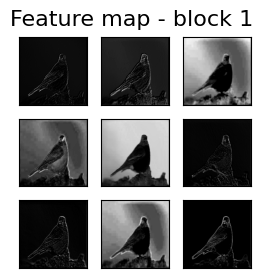

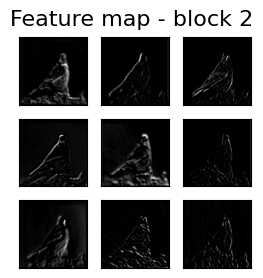

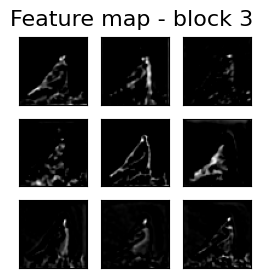

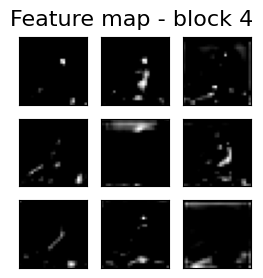

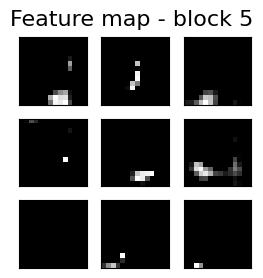

In [57]:
# summarize feature map size for each conv layer
from keras import Model
from keras.applications.vgg16 import VGG16, preprocess_input
import matplotlib.pyplot as plt

from tensorflow.keras.utils import load_img, img_to_array
from tensorflow import expand_dims

# load the model
model = VGG16()

# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]

outputs = [model.layers[i].output for i in ixs]

model = Model(inputs=model.inputs, outputs=outputs)

# load the image with the required shape
img = load_img("Figures/bird.jpg", target_size=(224, 224))

# convert the image to an array
img = img_to_array(img)

# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)

# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)

# get feature map for first hidden layer
feature_maps = model.predict(img)

# plot the output from each block
square = 3
k = 0
for fmap in feature_maps:

    fig = plt.figure(figsize=(square, square))

    # plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)

            ax.set_xticks([])
            ax.set_yticks([])

            # plot filter channel in grayscale
            plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1

    fig.suptitle(f'Feature map - block {k+1}', fontsize=16, position=(0.5, 0.97))

    plt.savefig(f'feature_map_{ixs[k]}.png', dpi=300, bbox_inches='tight')

    k += 1

1/1 [==============================] - 0s 30ms/step


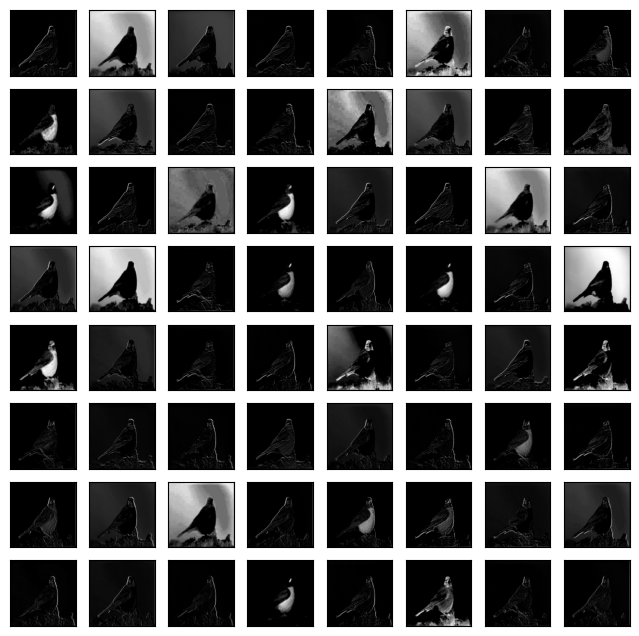

In [33]:
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)

img = load_img("Figures/bird.jpg", target_size=(224, 224))

# convert the image to an array
img = img_to_array(img)

# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)

img = preprocess_input(img)

feature_maps = model.predict(img)

fig = plt.figure(figsize=(8, 8))

square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix - 1], cmap="gray")
        ix += 1

# Ecological Systems

## Ocean acidification

In [23]:
import xarray as xr

from scipy.stats import linregress

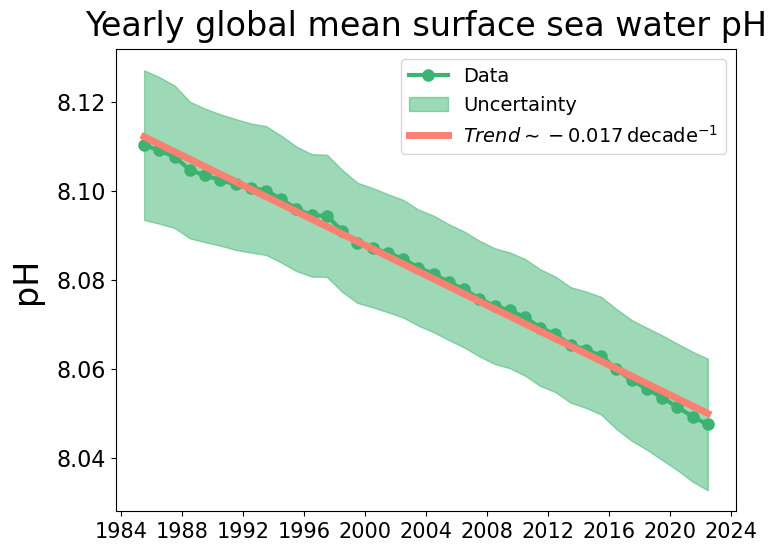

In [115]:
data = xr.open_dataset("/home/alex/Downloads/ph_data.nc")

ph = data["ph"].values
time = data["time"].values
uncertainty = data["ph_uncertainty"].values

time_years = (time - time[0]).astype("timedelta64[D]").astype(int) / 365

slope, intercept, r_value, p_value, std_err = linregress(time_years, ph)

plt.figure(figsize=(8, 6))

plt.plot(time, ph, color="mediumseagreen", lw=3, marker="o", markersize=8, label="Data")

plt.fill_between(
    time, ph - uncertainty, ph + uncertainty, color="mediumseagreen", alpha=0.5, label="Uncertainty"
)

plt.plot(
    time,
    slope * time_years + intercept,
    color="salmon",
    lw=5,
    label=r"$Trend\sim %.3f \, \mathrm{decade}^{-1}$" %(slope * 10),
)

plt.ylabel(r'pH', fontsize=24, labelpad=10)

plt.title('Yearly global mean surface sea water pH', fontsize=24, pad=10)

plt.xticks(fontsize=15)

plt.legend(fontsize=14)

plt.savefig("Ocean_acidification.pdf", dpi=300, bbox_inches="tight")

In [51]:
slope

-0.0016788094283825027